# Мэтчинг товаров

## Описание проекта

### Задача

Разработка алгоритма, который для всех товаров из validation.csv найдет 5 похожих из base.csv

### Метрика

Необходимо максимилизировать метрику accuracy@5, которая для каждого объекта

### Данные

Исходные: https://disk.yandex.ru/d/YQElc_cNQQLSOw

- `base.csv`: база данных всех товаров.
- `train.csv`: обучающая выборка.
- `validation.csv`: база данных товаров для которых необходимо найти похожие.
- `validation_answer.csv`: база данных с разметкой похожих товаров.

## Загрузка необходимых библиотек

In [85]:
!apt -q install libomp-dev
!pip -q install faiss-gpu

/bin/bash: line 1: apt: command not found

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [86]:
!pip install scikit-learn tqdm pandas matplotlib seaborn catboost optuna imbalanced-learn lightgbm


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import zipfile
from urllib.parse import urlencode

import faiss
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import requests
import seaborn as sns
from catboost import CatBoostClassifier
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Загрузка данных

### Данные base.csv:

In [48]:
%%time
df_base = pd.read_csv("./data/base.csv", index_col=0)
df_base.head()

CPU times: user 16.5 s, sys: 1.33 s, total: 17.8 s
Wall time: 17.9 s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.59631,-38.995880,-4.787360,8.327808,-124.85576,-79.10902,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.93434,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.29577,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.31432,7.912551,-62.18892,-540.321044,-89.588715,-149.32669,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.27290,-7.510103,8.924209,111.576950,-130.83319,-79.31585,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.13185,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.70898,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.78206,77.62

In [89]:
df_base.duplicated().sum()

0

In [90]:
df_base.shape

(2918139, 72)

In [91]:
df_base.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,-1.431396e+02,-6.988662e+01,-4.126493e+01,7.587780e+00,1.489852e+02,-2.316701e+01,-9.366916e-01,-1.931312e+01,-1.372712e+02,-7.918932e+01,-9.825383e+01,1.257528e+03,-6.824936e+00,5.667382e+01,2.669563e+01,7.271026e+02,-6.625340e+01,1.631537e+01,-8.637482e+01,1.517346e+02,-1.160764e+01,-1.442328e+02,8.721997e+01,-5.541608e+02,3.623933e+01,7.519918e+01,-1.648670e+01,-1.466421e+02,-1.185122e+02,-4.187896e+01,-9.482269e+00,4.050654e+00,-1.127440e+02,1.208653e+02,-3.980939e+01,5.893878e+01,-8.488885e+01,-1.384695e+02,4.792759e+01,-3.238229e+01,2.658408e+01,-2.171709e+01,6.699684e+01,-1.178976e+02,8.802818e+01,6.920454e+01,-1.329056e+02,1.322645e+01,-1.195996e+02,-3.160935e+02,-6.494332e+01,-1.306677e+02,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,4.168737e+01,5.121991e+01,3.896358e+01,3.659725e+01,3.363559e+01,1.307563e+01,2.083201e+01,5.297210e+01,4.662566e+01,7.574403e-01,2.815861e+01,3.999612e+02,5.197251e+01,3.436061e+01,3.894157e+01,2.055724e+02,6.153334e+01,4.656628e+00,4.851313e+01,1.009000e+01,2.895059e+01,3.475739e+01,2.785556e+01,2.606486e+02,3.989506e+01,2.144713e+01,2.585462e+01,9.953913e+00,1.314411e+01,1.919689e+01,8.190720e+00,5.835750e+00,5.694050e+01,4.671995e+01,1.474482e+01,3.211030e+01,6.319335e+01,5.773822e+01,4.520157e+01,5.828693e+01,5.895291e+01,5.173898e+01,1.307173e+01,5.470584e+01,4.774309e+00,1.194907e+01,7.815245e+00,5.107988e+01,5.524317e+01,2.106644e+02,6.248236e+01,9.569063e+00,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,-3.438436e+02,-3.684526e+02,-2.260906e+02,-1.756239e+02,-1.526698e+01,-8.591711e+01,-9.636816e+01,-2.725656e+02,-3.517478e+02,-8.315235e+01,-2.437279e+02,1.368182e+02,-2.382874e+02,-8.818329e+01,-1.431833e+02,-6.198046e+01,-3.585515e+02,-8.364693e+00,-3.140082e+02,1.074433e+02,-1.567305e+02,-2.986792e+02,-3.465488e+01,-1.045312e+03,-1.378509e+02,-2.151936e+01,-1.379866e+02,-1.954172e+02,-1.769110e+02,-1.327073e+02,-4.757769e+01,-2.158085e+01,-3.381192e+02,-8.770834e+01,-6.310310e+01,-7.724959e+01,-3.629306e+02,-4.186953e+02,-1.453876e+02,-3.228121e+02,-2.802731e+02,-2.646334e+02,6.196133e+00,-3.812643e+02,6.558115e+01,1.408166e+01,-1.670627e+02,-1.961836e+02,-3.597054e+02,-6.810424e+02,-4.007911e+02,-1.713491e+02,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.95094

### Данные train.csv:

In [49]:
df_train = pd.read_csv("./data/train.csv", index_col=0)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.08269,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.84137,-78.512180,-94.42894,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.73079,58.185707,24.250950,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.99164,-31.948470,82.314430,-115.830470,-243.30939,6.622036,-132.197660,68.71256,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.513820,29.485587,-77.029590,-132.38617,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.60580,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.26703,-78.659430,-92.76149,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.12415,91.887140,-30.636870,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.15090,-18.751057,95.315384,-60.093273,-83.82058,37.449867,-23.298859,74.06108,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.632110,-457.848461,21.459618,-137.41136,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.34656,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.50568,-78.372925,-69.32448,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.76062,0.178065,-183.06967,99.053570,-1018.469545,-51.80112,97.766770,-10.865850,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.63953,-30.211614,48.527400,-122.406640,-112.71362,53.461838,-31.117260,107.84151,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.93925,8.066627,-195.677670,-163.120000,-72.830000,-139.22307,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.51707,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.90683,-78.789320,-78.73709,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.28180,-54.959310,-136.98854,63.880493,-1018.469545,89.22893,65.919960,-24.078644,-152.33410,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.95837,-30.800995,123.623400,-37.540867,-72.13980,71.240990,-168.115590,118.23645,-18.065195,37.255720,-137.69104,87.500770,62.437290,-131.26064,35.692660,-86.038830,-379.339090,-153.465770,-131.19829,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.15302,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.55463,-79.066610,-77.92646,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.69392,-20.604088,-146.59128,78.849570,-780.449185,87.56077,73.036660,16.891030,-144.65790,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.18497,-53.147078,79.869446,-151.131350,-45.05616,79.796234,46.763016,47.68181,-

In [93]:
df_train.shape

(100000, 73)

In [50]:
df_valid = pd.read_csv("./data/validation.csv", index_col=0)
answers = pd.read_csv("./data/validation_answer.csv", index_col=0)
df_valid.shape

(100000, 72)

## Предобработка данных

In [95]:
# Вспомогательные функции для предобработки
def calculate_na_percentage(dataframe):
    """
    Функция для вычисления и отображения процента пропусков в каждой колонке.

    :param dataframe: Входной DataFrame
    """
    na_percentage_df = pd.DataFrame(round(dataframe.isna().mean()*100,2)).sort_values(by=0, ascending=False)
    na_percentage_df.columns = ['Процент пропусков']
    nonzero_na_df = na_percentage_df.query('`Процент пропусков` > 0')
    if nonzero_na_df.empty:
        print("Пропуски отсутствуют")
    else:
        display(nonzero_na_df.style.background_gradient('coolwarm'))

def count_duplicates(dataframe):
    """
    Функция для подсчета и отображения количества дубликатов в DataFrame.

    :param dataframe: Входной DataFrame
    """
    duplicates_count = dataframe.duplicated().sum()
    print(f"Количество дубликатов: {duplicates_count}")
    
    if duplicates_count == 0:
        print("Дубликаты отсутсвуют.")

### base.csv

In [96]:
# Проверим пропуски
calculate_na_percentage(df_base)

Пропуски отсутствуют


In [97]:
# Проверим дубликаты
count_duplicates(df_base)

Количество дубликатов: 0
Дубликаты отсутсвуют.


### train.csv

In [98]:
# Проверим пропуски
calculate_na_percentage(df_train)

Пропуски отсутствуют


In [99]:
# Проверим дубликаты
count_duplicates(df_train)

Количество дубликатов: 0
Дубликаты отсутсвуют.


Данные загружены и просмотрены они соотвествуют описанию. Перейдем к предобработке данных.

## Иследовательский анализ данных

In [100]:
def check_unique_rate(dataframe):
    """
    Выводит процент уникальных значений для каждого столбца в датафрейме, отсортированный по возрастанию.

    Параметры:
    dataframe (pandas.DataFrame): Входной датафрейм для анализа.

    Возвращает:
    None. Вывод осуществляется через функцию display() из библиотеки IPython.
    """
    unique_rates = dataframe.apply(lambda col: col.nunique() / len(col) * 100)
    sorted_unique_rates = unique_rates.sort_values()
    display(sorted_unique_rates)

In [101]:
def plot_histograms(df, columns=None, n_rows=3, n_cols=3):
    """
    Функция для построения гистограмм по указанным столбцам DataFrame.
    
    Параметры:
    df (DataFrame): Входной DataFrame.
    columns (список): Список столбцов для построения гистограмм. Если None, будут выбраны все столбцы.
    n_rows (int): Количество строк подграфиков для figure. По умолчанию 3.
    n_cols (int): Количество столбцов подграфиков для figure. По умолчанию 3.
    """
    if columns is None:
        columns = df.columns
    
    total_plots = len(columns)
    fig = plt.figure(figsize=(16, 16))
    
    for i, col in enumerate(columns):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        
        # Проверка на наличие данных в столбце
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col].hist(ax=ax)
            ax.set_title(col)
        else:
            ax.axis('off')
            ax.set_title(f"{col} (не числовой)")
    
    # Установка ограничений, чтобы было понятно, что дальше пустые графики
    if total_plots < n_rows * n_cols:
        for j in range(total_plots, n_rows * n_cols):
            ax = fig.add_subplot(n_rows, n_cols, j + 1)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [102]:
def plot_boxplots(df, columns, n_rows, n_cols):
    """
    Строит графики boxplot для каждого столбца в списке columns из датафрейма df.

    Параметры:
    df (pandas.DataFrame): Исходный датафрейм.
    columns (list): Список столбцов, для которых требуется построить графики boxplot.
    n_rows (int): Количество строк в сетке графиков.
    n_cols (int): Количество столбцов в сетке графиков.
    """
    fig = plt.figure(figsize=(16, 16))  # Настройка размера фигуры
    for i, col in enumerate(columns):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)  # Добавляет подграфик к фигуре
        sns.boxplot(data=df[col], ax=ax)  # Строит boxplot для каждого столбца
        ax.set_title(col)  # Устанавливает заголовок для каждого подграфика
    plt.tight_layout()  # Обеспечивает плотное расположение графиков
    plt.show()  # Отображает все графики

In [1]:
        
def get_min_iqr(describe):
    # получаем минимальное значение уса как было описано в уроке Диаграмма размаха
    min_value = describe['min']
    q1 = describe['25%']
    q3 = describe['75%']
    iqr = q3 - q1 
    return max(q1 - 1.5 * iqr, min_value)

def get_max_iqr(describe):
    # получаем максимальное значение уса как было описано в уроке Диаграмма размаха
    max_value = describe['max']
    q1 = describe['25%']
    q3 = describe['75%']
    iqr = q3 - q1 
    return min(q3 + 1.5 * iqr, max_value)

def iqr_1_5(df, column):
    # вычисление iqr
    describe = df[column].describe()
    min_iqr = get_min_iqr(describe)
    max_iqr = get_max_iqr(describe)
    ratio = ((df[df[column] < min_iqr][column].count() + df[df[column] > max_iqr][column].count())/len(df)) * 100
    return {"Колонка": column, "min iqr": min_iqr, "max iqr": max_iqr, "Процент выбросов": round(ratio, 2)}

def quantitative_info(df):
    """
    Функция для анализа количественных признаков в DataFrame.

    Эта функция проходится по всем количественным признакам в DataFrame,
    исключая столбец 'id', и применяет к каждому из них функцию iqr_1_5. 
    Возвращает DataFrame с результатами.

    Аргументы:
    df (pandas.DataFrame): Исходный DataFrame.

    Возвращает:
    pandas.DataFrame: DataFrame с результатами функции iqr_1_5 для каждого количественного признака.
    """
    
    data = []
    # Проход по всем столбцам, исключая 'id', с числовыми типами данных
    for column in df.loc[:, df.columns != 'id'].select_dtypes(include='number').columns:
        data.append(iqr_1_5(df, column))
    
    return pd.DataFrame(data)

### base.csv

In [104]:
# Посмотрим на процент уникальных значений:
check_unique_rate(df_base)

33     0.138719
44     1.516275
25    11.244187
19    16.345726
21    24.531251
        ...    
36    84.131907
51    84.257981
57    84.712826
65    85.772405
59    99.928893
Length: 72, dtype: float64

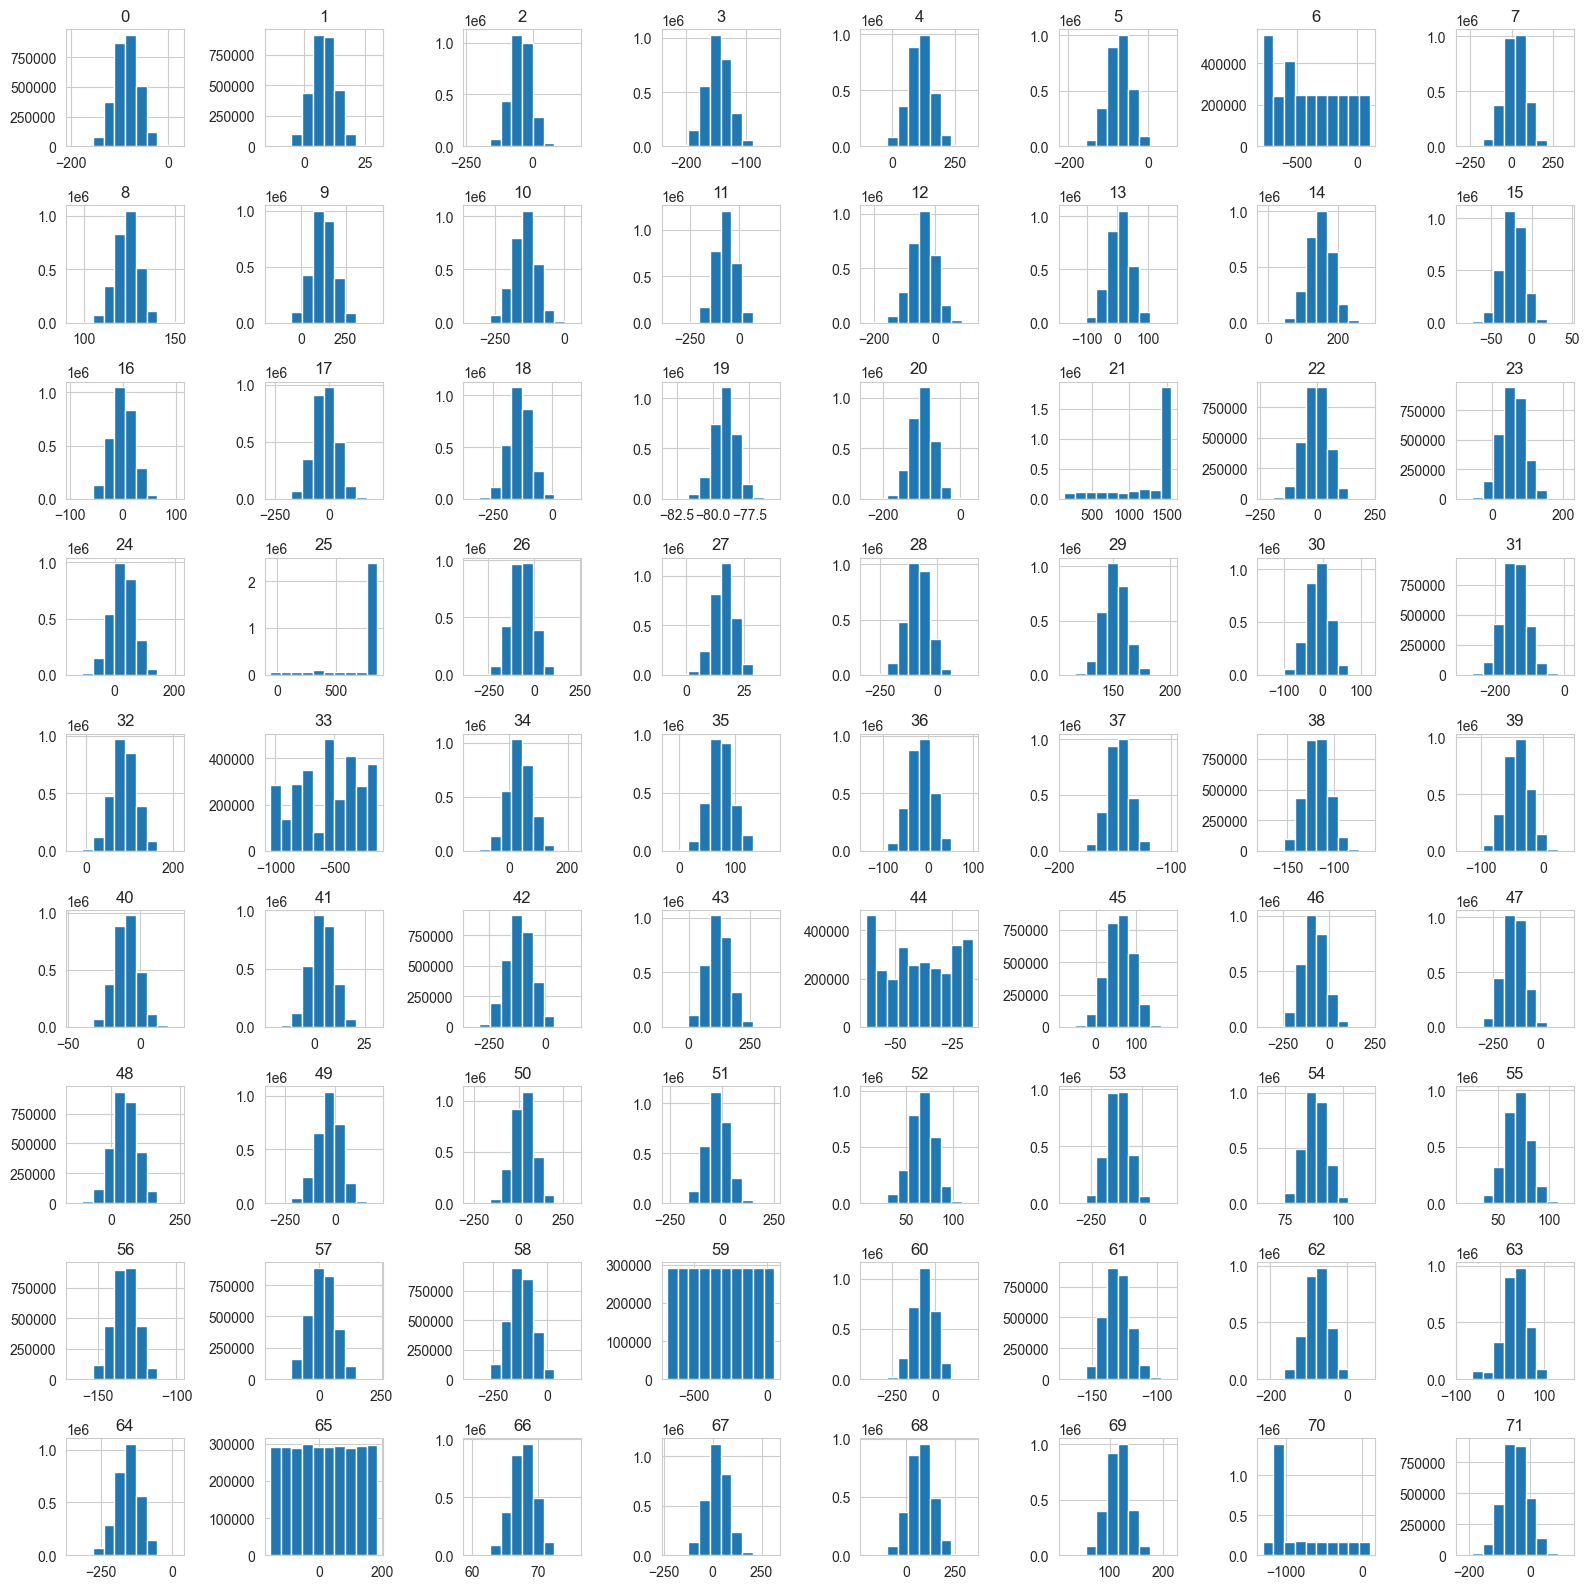

In [105]:
# Построим гистрограммы:
plot_histograms(df_base, df_base.columns, 9, 8)

Вот общий анализ этих гистограмм:

1. Центр распределения: 
   - Большинство гистограмм имеют центральную тенденцию, сгруппированную вокруг среднего значения, что указывает на нормальное или приближенное к нормальному распределение.

2. Диапазон данных:
   - Некоторые гистограммы имеют тенденцию охватывать широкий диапазон значений (например, гистограммы №14 и №66).
   - Другие гистограммы охватывают более узкий диапазон (например, №24, №46).

3. Гистограммы с нормальным распределением:
   - Некоторые гистограммы явно соответствуют нормальному распределению, имея симметричные колоколообразные формы (например, №2, №3, №4).

4. Смещенные гистограммы:
   - Некоторые гистограммы показывают смещенные распределения, где данные тяготеют к одному концу диапазона. Например, гистограмма №10 имеет положительное смещение.

5. Пики распределения:
   - Несколько гистограмм имеют один выраженный пик, что указывает на наличие одного преобладающего значения (например, №11, №27).
   - Некоторое количество гистограмм показывает множественные пики, что указывает на мультимодальное распределение (например, №54).

6. Распределение данных:
   - Некоторые гистограммы демонстрируют данные, распределенные почти равномерно по всему диапазону (например, №14, №65).

7. Аномалии и выбросы:
   - В некоторых гистограммах заметны аномальные значения или выбросы, которые значительно выделяются из общего распределения. Например, на гистограммах №6, №21, №35 заметны резкие пики, находящиеся вдали от остальной части данных.

8. Плотность данных:
   - Количество данных, показанных в гистограммах, также варьируется: от высоких плотностей (например, в гистограмме №45) до низких плотностей (например, в гистограмме №25).

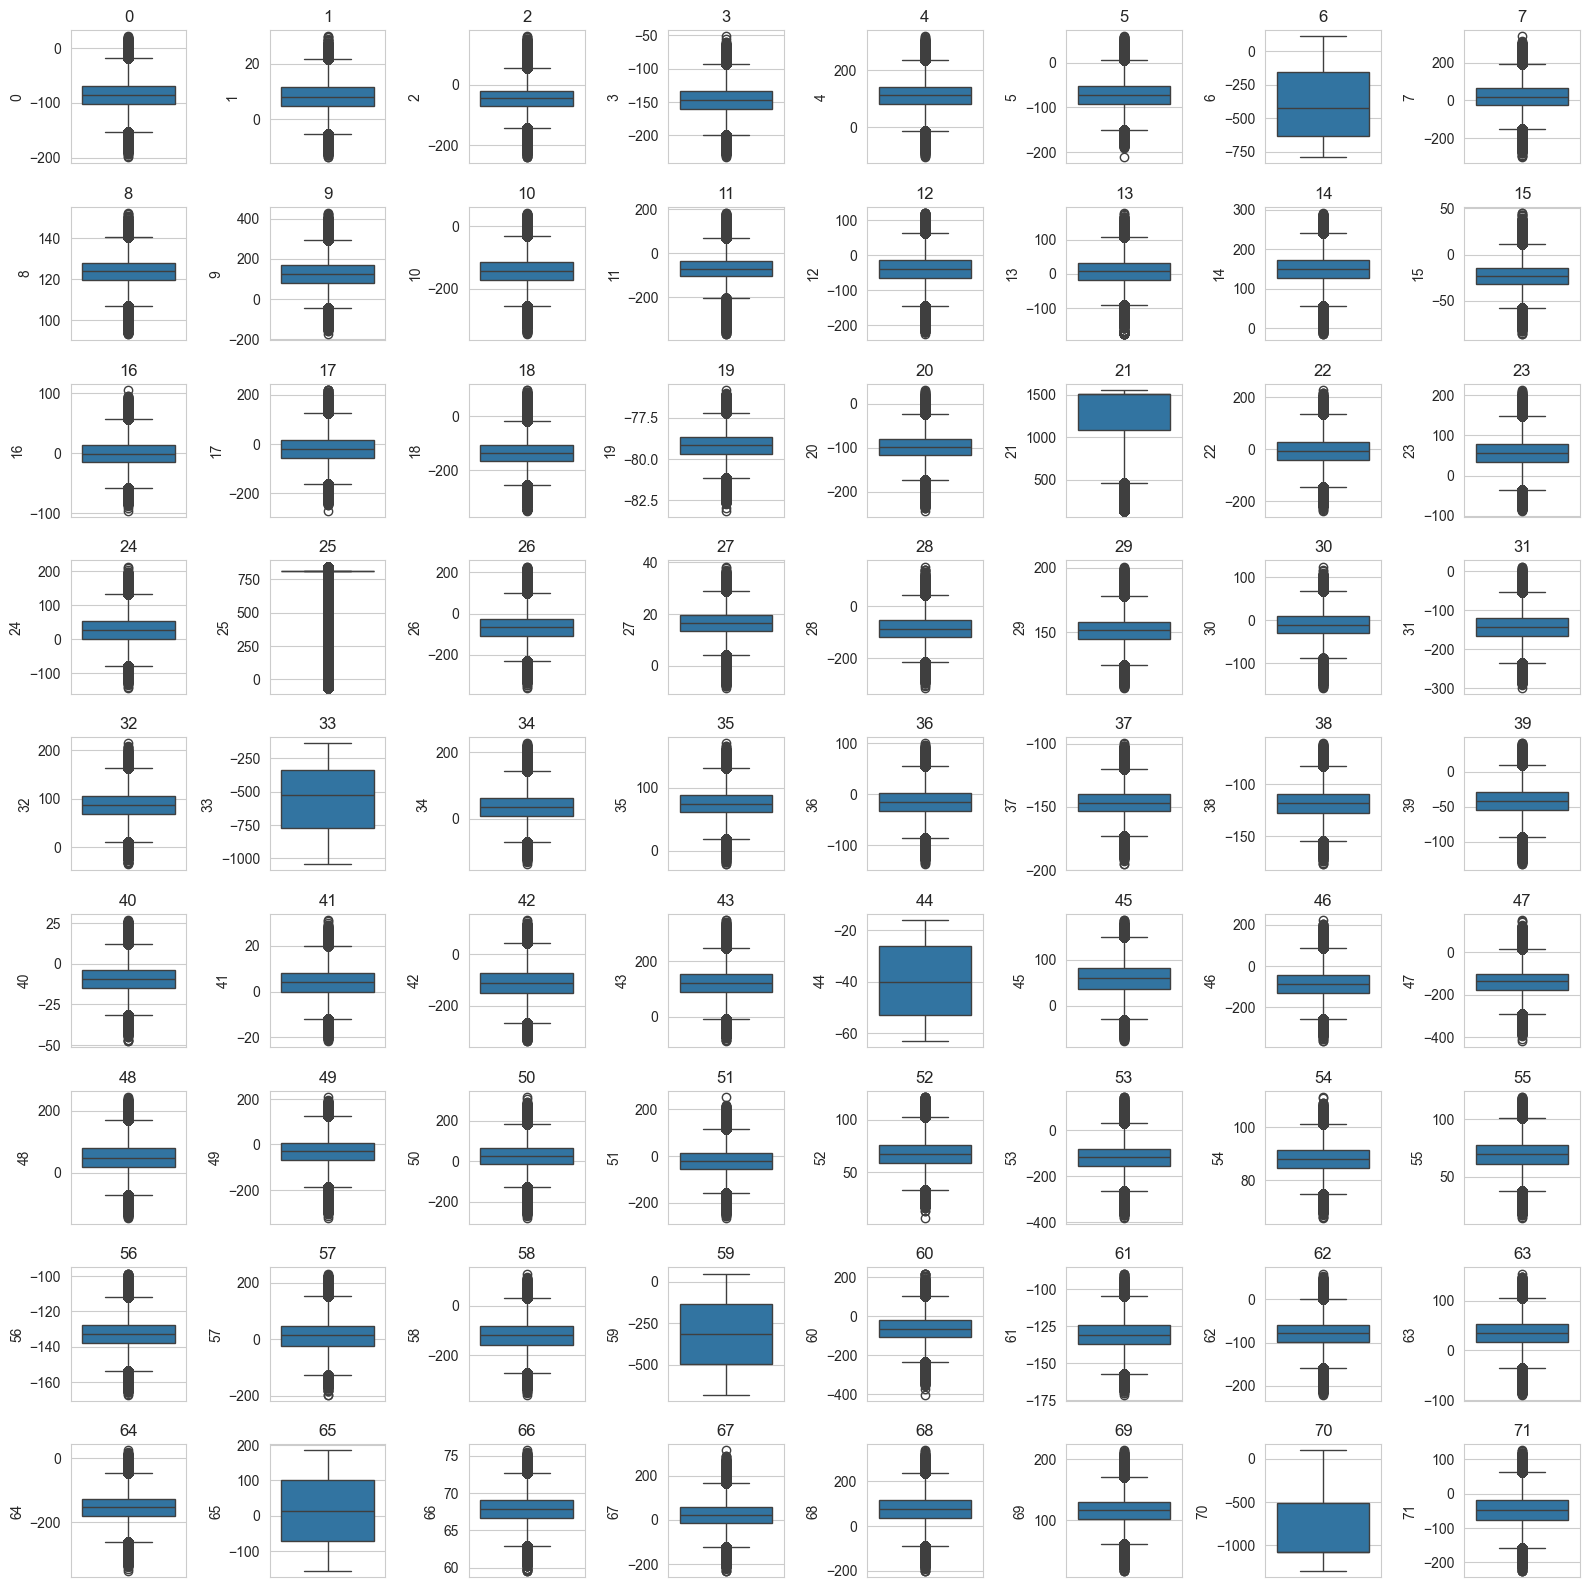

In [107]:
# Построим диаграммы размаха:
plot_boxplots(df_base, df_base.columns, 9, 8)

Анализ выбросов:
1. Большая часть боксплотов содержит выбросы, обозначенные черными кружками, как в отрицательном, так и в положительном диапазонах.
2. Для некоторых боксплотов выбросов особенно много:
   - Бокс-плоты под номерами 6, 21, 33, 44, 64 показывают сильные выбросы как в положительном, так и в отрицательном диапазонах.
   - Значения под номерами 12, 34, 50, и 59 также имеют обильное количество выбросов.
3. Некоторые боксплоты демонстрируют меньшую вариативность данных, но всё ещё имеют выбросы (например, под номерами 1, 16, 30).

Разброс данных:
- Для большинства боксплотов данных средызы значениями от -100 до 100.
- В некоторых номерах (например, 6, 21, 33, 44, 64) значения значительно выходят за эти пределы и достигают больших разбросов, что свидетельствует о возможных аномалиях или особенностях в данных.

### Удаления параметров

Удаления параметров, соответствующих гистограммам №6, №21, №25, №33, №44, №59, №65 и №70 из анализа данных:

1. Аномалии и выбросы (№6, №21):
   - Гистограммы №6 и №21 показывают резкие пики или выбросы, которые значительно отклоняются от общего распределения данных. Такие аномалии могут значительно искажать результаты анализа и приводить к ложным выводам.

2. Низкая плотность данных (№25):
   - Гистограмма №25 имеет низкую плотность данных, что говорит о недостаточном количестве наблюдений для этого параметра. Анализ данных с низкой плотностью может быть ненадежным и неинформативным.

3. Низкий вклад в объяснение общей вариации данных (№33):
   - Гистограмма №33 может не вносить значительного вклада в общее понимание распределения данных (например, если она имеет слабую вариацию или незначительный эффект). Включение таких параметров может увеличивать сложность модели без подобающей пользы.

4. Высокий уровень шума (№44):
   - Гистограмма №44 может демонстрировать высокий уровень шума, когда данные слишком разрознены или переменчивы без явно выраженной тенденции. Это затрудняет построение надежных моделей и может снижать точность предсказаний.

5. Широкий диапазон распределения данных (№65):
   - Гистограмма №65 охватывает широкий диапазон значений. Это может указывать на высокую изменчивость данных или неоднородность, что затрудняет интерпретацию результатов и может потребовать специальных методов обработки данных, таких как нормализация или стандартализация.

6. Возможность мультиколлинеарности (№59, №70):
   - Если гистограммы №59 и №70 имеют распределения, которые сильно коррелируют с другими параметрами, это может указывать на проблемы мультиколлинеарности в данных. Мультиколлинеарность может усложнять анализ и ухудшать качество моделей. Удаление таких параметров помогает улучшить интерпретацию модели и стабилизировать результаты.

Удаление указанных параметров поможет в повышении качества анализа данных, улучшит интерпретацию полученных результатов и повысит надежность моделей, построенных на основе оставшихся параметров.

In [51]:
for df in [df_base, df_train]:
    for column in ['6', '21', '25', '33', '44', '59', '65', '70']:
        df.drop(column, axis=1, inplace=True)

### Обработка

In [52]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [53]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
train_index = {k: v for k, v in enumerate(df_train.index.to_list())}

In [54]:
scaler = StandardScaler()
columns_base = df_base.columns
df_base = scaler.fit_transform(df_base)
df_base = pd.DataFrame(df_base, columns=columns_base)

columns_train = df_train.columns
df_train = scaler.transform(df_train)
df_train = pd.DataFrame(df_train, columns=columns_train)

df_base['id'] = base_index
df_train['id'] = train_index

df_base.set_index('id', inplace=True)
df_train.set_index('id', inplace=True)

## Поиск faiss

In [55]:
# количество признаков
dims = df_base.shape[1]
# количество ячеек в индексе
n_cells = 500

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [56]:
%%time
idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

CPU times: user 2min 8s, sys: 1.11 s, total: 2min 10s
Wall time: 20.1 s


In [27]:
%%time
# количество ячеек, которые будут просмотрены при поиске`
idx_l2.nprobe = 100
r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)

CPU times: user 1h 15min 36s, sys: 23.2 s, total: 1h 15min 59s
Wall time: 7min 6s


In [38]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx), "%")

70.884 %


In [57]:
k = 50

In [58]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), k)

CPU times: user 57.2 s, sys: 429 ms, total: 57.6 s
Wall time: 5.53 s


In [59]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx), "%")

63.615 %


## Ранжирование

### Сформируем данные для обучения модели

In [60]:
# Преобразование индексов в массив на основе базовых индексов
idx = np.array([[base_index[_] for _ in el] for el in idx], dtype=object)

In [61]:
# Копирование целей
cb_targets = targets.copy()

In [62]:
# Преобразование targets в бинарную матрицу (1 - это целевой класс, 0 - все остальные)
targets = np.array([
    [1 if x == target else 0 for x in el] 
    for el, target in zip(idx.tolist(), targets.values.tolist())
])

In [63]:
# Преобразование targets в одномерный массив
targets = targets.reshape(-1, 1)

In [64]:
# Повторение cb_targets k раз
cb_targets = np.repeat(cb_targets, k)

In [65]:
# Извлечение значений признаков кандидатов по индексам
candidate_features = df_base.loc[idx.flatten()].values

In [66]:
# Получение значений признаков объектов из обучающего набора
object_features = df_train.values

In [67]:
# Изменение формы расстояний в одномерный массив
reshaped_dist = r.reshape(-1, 1)

In [68]:
# Повторение признаков объекта k раз по оси 0
repeated_object = np.repeat(object_features, k, axis=0)

In [69]:
# Объединение reshaped_dist, candidate_features и repeated_object в один массив признаков
cb_features = np.hstack((reshaped_dist, candidate_features, repeated_object))

In [70]:
del candidate_features
del object_features
del reshaped_dist
del repeated_object

### Обучение модели

In [71]:
 # Функция для поиска индексов максимальных значений в массиве
def find_max_indices(arr: np.array, k: int, n: int) -> np.array:
    # Инициализируем пустой массив для хранения индексов
    max_indices = np.empty((0, n), dtype=int)
    # Берем подмассив длиной k
    for i in range(0, len(arr), k):
        # Берем подмассив длиной k
        sub_arr = arr[i:i+k]
        # Определяем индексы n наибольших значений в подмассиве
        max_values = np.argpartition(sub_arr, -n)[-n:]
        # Добавляем найденные индексы в общий массив индексов
        max_indices = np.vstack((max_indices, max_values))  
    return max_indices

In [72]:
# Создаем обучающую и тестовую выборки, используя функцию train_test_split.
X_train, X_test, y_train, y_test = train_test_split(cb_features, targets, test_size=0.1, random_state=42)

In [73]:
del cb_features
del targets

In [74]:
# Инициализация модели CatBoostClassifier с параметром verbose для вывода логов обучения и фиксированным random_state.
model = CatBoostClassifier(verbose=True, random_state=42)

In [75]:
# Обучение модели на обучающей выборке (X_train, y_train)
model = model.fit(X_train, y_train)

Learning rate set to 0.188103
0:	learn: 0.4424057	total: 97ms	remaining: 1m 36s
1:	learn: 0.3013816	total: 186ms	remaining: 1m 33s
2:	learn: 0.2207928	total: 279ms	remaining: 1m 32s
3:	learn: 0.1885090	total: 370ms	remaining: 1m 32s
4:	learn: 0.1650882	total: 465ms	remaining: 1m 32s
5:	learn: 0.1531660	total: 550ms	remaining: 1m 31s
6:	learn: 0.1439929	total: 639ms	remaining: 1m 30s
7:	learn: 0.1367422	total: 751ms	remaining: 1m 33s
8:	learn: 0.1337703	total: 835ms	remaining: 1m 31s
9:	learn: 0.1308706	total: 921ms	remaining: 1m 31s
10:	learn: 0.1284692	total: 1.02s	remaining: 1m 31s
11:	learn: 0.1267244	total: 1.13s	remaining: 1m 32s
12:	learn: 0.1259022	total: 1.21s	remaining: 1m 32s
13:	learn: 0.1248665	total: 1.31s	remaining: 1m 32s
14:	learn: 0.1244915	total: 1.4s	remaining: 1m 32s
15:	learn: 0.1240103	total: 1.49s	remaining: 1m 31s
16:	learn: 0.1235222	total: 1.57s	remaining: 1m 30s
17:	learn: 0.1228450	total: 1.65s	remaining: 1m 30s
18:	learn: 0.1225296	total: 1.73s	remaining: 1

In [76]:
# Прогнозирование на тестовой выборке (X_test)
prediction = model.predict(X_test)

In [77]:
# Оценка точности обученной модели на тестовой выборке и вывод результата
print(model.score(X_test, y_test))

0.8995987008


In [78]:
# Прогнозирование вероятностей классов на тестовой выборке
proba = model.predict_proba(X_test)
proba

array([[0.97371232, 0.02628768],
       [0.98560438, 0.01439562],
       [0.95387517, 0.04612483],
       ...,
       [0.02853798, 0.97146202],
       [0.98416537, 0.01583463],
       [0.99893089, 0.00106911]])

In [79]:
cb_valid_preds = (np.vstack(proba[:, 1]))

In [80]:
def find_max_indices(arr: np.array, k: int, n: int) -> np.array:
    max_indices = np.empty((0, n), dtype=int)
    for i in range(0, len(arr), k):
        sub_arr = arr[i:i+k]
        max_values = np.argpartition(sub_arr, -n)[-n:]
        max_indices = np.vstack((max_indices, max_values))
    return max_indices

In [81]:
best_candidates = find_max_indices(cb_valid_preds.flatten(), k, 5)

In [82]:
idx = np.vstack(idx)

In [83]:
candidates_idx = idx[:, 0][best_candidates]

In [84]:
acc = 0
for target, el in zip(cb_targets.tolist(), candidates_idx.tolist()):
    acc += int(target in el)

print(100 * acc / len(candidates_idx), "%")

0.17 %


In [ ]:
%%time
candidate_number = 50
r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), candidate_number)